<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#downloading helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


--2022-06-07 08:50:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-07 08:50:06 (83.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#tensorflow datasets
import tensorflow_datasets as tfds

In [3]:
dataset_list=tfds.list_builders()# lits of all tensorflos datasets


tensorflow datasets , are in tensors ready to work with

In [4]:
(train_data,test_data),ds_info=tfds.load("food101",split=["train","validation"],
                                         shuffle_files=True,as_supervised=True,#out data gets returned in tuple format(data,label) for supervised learning  
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIPLKQJ/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIPLKQJ/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
class_names=ds_info.features["label"].names# class names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
train_sample=train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
for image,label in train_sample:
   print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
  


In [8]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'spaghetti_bolognese')

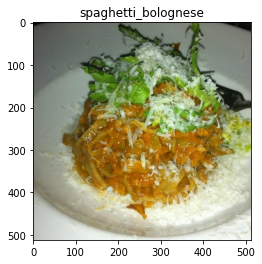

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list


In [10]:
def preprocess_img(image,label,img_shape=224):
  """
  converts image datatype from unit8 to float 32 and reshape image 
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [11]:
preproccesed=preprocess_img(image,label)[0]
print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


#batch and prepare datasets

In [12]:
#map preprocessing for training data
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)#use most of cpu for execute  
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#map preprocessing for test data
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#creating modelling callback

In [16]:
#create tensorboard 
from helper_functions import create_tensorboard_callback

checkpoint_patch="model_checkpoins/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_patch,monitor="val_acc",save_best_only=True,save_weights_only=True,verbose=0)